#### 1. Import Libraries : Import necessary Python libraries for data manipulation, visualization, and clustering

In [1]:
#pip install --upgrade pandas seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

#### 2. Load Data : Load the dataset into a pandas DataFrame.
#### 3. Data Dictionary : Load a data dictionary that describes the dataset

In [3]:
data = pd.read_csv('ML3 data.csv')
cd = pd.read_excel('Data_Description.xlsx')

In [4]:
data.head(2)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
0,73557,8,2,1,69,NaN,4,4,1,NaN,...,1.470207,4.864849,3.636711,-9.174492,-9.353410,5.153847,1.294983,-1.015693,-8.671692,5.423061
1,73558,8,2,1,54,NaN,3,3,1,NaN,...,-7.363791,-2.566326,0.776046,-2.951925,-0.538597,3.770290,6.711471,3.521875,-1.765809,-5.383746


In [5]:
cd.head(2)

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,SEQN,Respondent sequence number.,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,NaN
1,SDDSRVYR,Data release cycle,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,NaN


#### 4. Initial Data Exploration : Check the shape of the DataFrame and the number of missing values.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 662 entries, SEQN to ar25
dtypes: float64(641), int64(21)
memory usage: 49.6 MB


In [7]:
data.shape

(9813, 662)

In [8]:
cd.shape

(636, 8)

In [9]:
data.isnull().sum().sum()

3326124

In [10]:
cd['Component'].unique()

array(['Demographics', 'Dietary', 'Laboratory'], dtype=object)

#### 5. Data Cleaning : Fill missing values in dietary columns with zeros based on the assumption that they are question answers.

In [11]:
dieteryColumns = cd[cd['Component'] == 'Dietary']["Variable Name"]
for col in dieteryColumns :
    data[col].fillna(0, inplace = True)

#### 6. Demographic Data Cleaning : Fill missing values in demographic columns with zeros.

In [12]:
demographicsColumns = cd[cd['Component'] == 'Demographics']["Variable Name"]
for col in demographicsColumns :
    data[col].fillna(0, inplace = True)

#### 7. Laboratory Data Cleaning : Fill missing values in laboratory columns with zeros.

In [13]:
labColumns = cd[cd['Component'] == 'Laboratory']["Variable Name"]
for col in labColumns :
    data[col].fillna(0, inplace = True)

#### 8. Final Missing Value Handling : Fill any remaining missing values in the dataset with zeros.

In [14]:
data.fillna(0, inplace = True)

#### 9. Feature Selection : Select numerical features for clustering and drop non-essential columns.

In [15]:
cd[cd['Component'] != 'Dietary'][cd['Component'] != 'Demographics'][cd['Component'] != 'Laboratory']

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints


In [16]:
print(data.shape)
print(cd.shape)

(9813, 662)
(636, 8)


In [17]:
main_features = pd.concat([dieteryColumns, demographicsColumns, labColumns], axis=0)
print(main_features)

47       WTDRD1
48       WTDR2D
49     DR1DRSTZ
50     DR1EXMER
51        DRABF
         ...   
631    URDUURLC
632     URXPREG
633      URXUAS
634      LBDB12
635    LBDB12SI
Name: Variable Name, Length: 636, dtype: object


In [18]:
data = data.drop_duplicates()
cd = cd.drop_duplicates()

In [19]:
data = data.loc[:, ~data.T.duplicated()]
cd = cd.loc[:, ~cd.T.duplicated()]

#### 10. Data Transformation : Scale the numerical features using MinMaxScaler

In [20]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#### 11. Optimal Cluster Identification : Use silhouette scores and the elbow method to find the optimal number of clusters for KMeans

In [21]:
from sklearn.cluster import KMeans

In [22]:
wcss = []
max_k_Check = 31
for k in range(1, max_k_Check):
    kmeans = KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

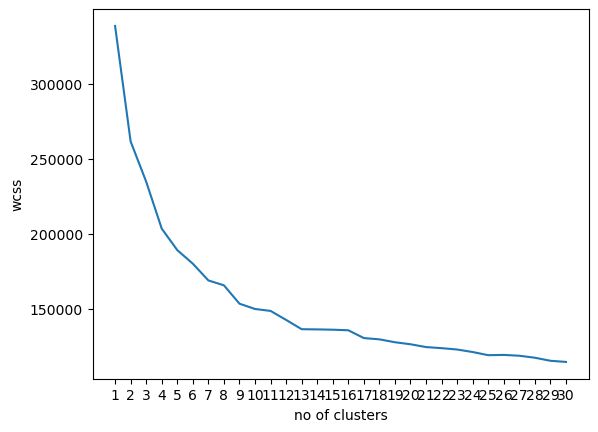

In [23]:
plt.plot(range(1,max_k_Check), wcss)
plt.xticks(range(1, max_k_Check))
plt.xlabel("no of clusters")
plt.ylabel("wcss")
plt.show()

In [24]:
k = 8 # Considered based on above plotted graph
kmeans = KMeans(n_clusters=k,init="k-means++")
data_pred = kmeans.fit_predict(data_scaled)

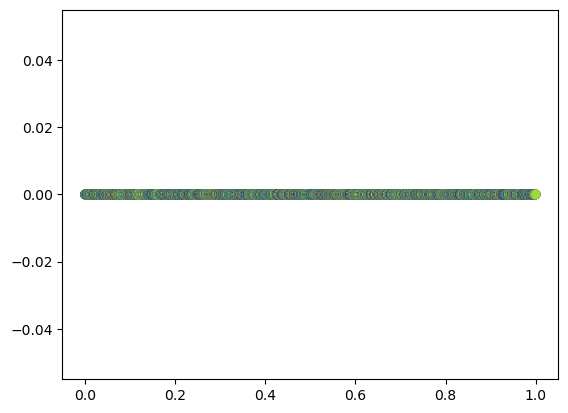

In [25]:
plt.scatter(data_scaled[:,0], data_scaled[:,1], c=data_pred)
plt.show()

In [26]:
from kneed import KneeLocator
kl = KneeLocator(range(1, max_k_Check), wcss, curve = "convex", direction = "decreasing")
elbow_k = kl.elbow
print(f"K value determined using elbow method is {elbow_k}")

K value determined using elbow method is 9


In [27]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []
for k in range(2, max_k_Check) :
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data_scaled)
    score = silhouette_score(data_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)
print(silhouette_coefficients)

[0.21439688115521463, 0.22111945469907934, 0.19764310861031503, 0.1829153594368111, 0.21122249206191132, 0.19457517428561186, 0.1886232250193183, 0.17799741668292565, 0.18891037412506567, 0.1775218337512489, 0.1629825648837097, 0.16718805987527102, 0.1519818261759445, 0.16430844398396494, 0.15643021166673943, 0.18229716411631186, 0.14825557194156055, 0.1548742301113938, 0.14022612360258327, 0.1390354357285383, 0.14740750897144947, 0.13869297603527556, 0.14420447431741834, 0.1374595009586591, 0.1407899369986727, 0.12653196928260174, 0.13754020302506548, 0.12765752415727355, 0.12978486473103998]


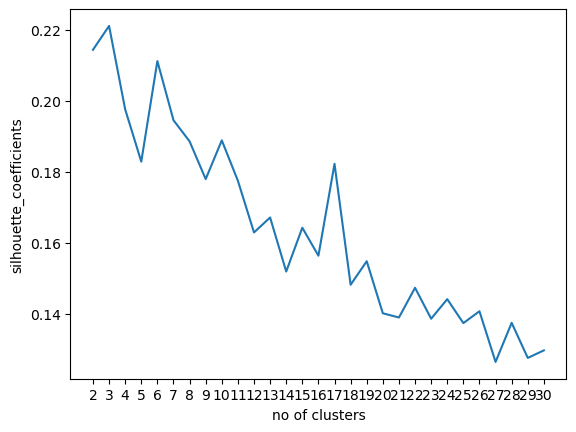

In [28]:
plt.plot(range(2, max_k_Check), silhouette_coefficients)
plt.xticks(range(2, max_k_Check))
plt.xlabel("no of clusters")
plt.ylabel("silhouette_coefficients")
plt.show()

#### 12. KMeans Clustering : Perform KMeans clustering with the identified optimal number of clusters.

In [29]:
kmeans = KMeans(n_clusters=elbow_k, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = cluster_labels

#### 13. Correlation Analysis : Analyze the correlation of features with the cluster labels to identify highly correlated features.

In [30]:
data.shape

(9813, 648)

In [31]:
data_scaled.shape

(9813, 648)

In [32]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns

In [33]:
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 20 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature DRD370C
Index(['DRD370A', 'DRD370B', 'DRD370D', 'DRD370E', 'DRD370F', 'DRD370G',
       'DRD370H', 'DRD370I', 'DRD370J', 'DRD370K', 'DRD370L', 'DRD370M',
       'DRD370N', 'DRD370O', 'DRD370P', 'DRD370Q', 'DRD370R', 'DRD370S',
       'DRD370T', 'DRD370U', 'DRD370V'],
      dtype='object')

----Corrleaton for the feature DRD370E
Index(['DRD370A', 'DRD370B', 'DRD370C', 'DRD370D', 'DRD370F', 'DRD370G',
       'DRD370H', 'DRD370I', 'DRD370J', 'DRD370K', 'DRD370L', 'DRD370M',
       'DRD370N', 'DRD370O', 'DRD370P', 'DRD370Q', 'DRD370R', 'DRD370S',
       'DRD370T', 'DRD370U', 'DRD370V'],
      dtype='object')

----Corrleaton for the feature DRD370F
Index(['DRD370A', 'DRD370B', 'DRD370C', 'DRD370D', 'DRD370E', 'DRD370G',
       'DRD370H', 'DRD370I', 'DRD370J', 'DRD370K', 'DRD370L', 'DRD370M',
       'DRD370N', 'DRD370O', 'DRD370P', 'DRD370Q', 'DRD370R', 'DRD370S',
       'DRD370T', 'DRD370U', 'DRD370V'],
      dtype='object')

----Corrleaton for the feature DR

In [34]:
highly_corr_cols_to_delete = ['DRD370A', 'DRD370B', 'DRD370D', 'DRD370E', 'DRD370F', 'DRD370G',
       'DRD370H', 'DRD370I', 'DRD370J', 'DRD370K', 'DRD370L', 'DRD370M',
       'DRD370N', 'DRD370O', 'DRD370P', 'DRD370Q', 'DRD370R', 'DRD370S',
       'DRD370T', 'DRD370U', 'DRD370V', 'ORXH06', 'ORXH11', 'ORXH16', 'ORXH18', 'ORXH26', 'ORXH31', 'ORXH33',
       'ORXH35', 'ORXH39', 'ORXH40', 'ORXH42', 'ORXH45', 'ORXH51', 'ORXH52',
       'ORXH53', 'ORXH54', 'ORXH55', 'ORXH56', 'ORXH58', 'ORXH59', 'ORXH61',
       'ORXH62', 'ORXH64', 'ORXH66', 'ORXH67', 'ORXH68', 'ORXH69', 'ORXH70',
       'ORXH71', 'ORXH72', 'ORXH73', 'ORXH81', 'ORXH82', 'ORXH83', 'ORXH84',
       'ORXHPC', 'ORXHPI', 'ORXHPV', 'LBDRLP.x', 'LBDR06.x', 'LBDR11.x', 'LBDR16.x', 'LBDR18.x', 'LBDR26.x',
       'LBDR31.x', 'LBDR33.x', 'LBDR35.x', 'LBDR39.x', 'LBDR40.x', 'LBDR42.x',
       'LBDR45.x', 'LBDR51.x', 'LBDR52.x', 'LBDR53.x', 'LBDR54.x', 'LBDR55.x',
       'LBDR56.x', 'LBDR58.x', 'LBDR59.x', 'LBDR61.x', 'LBDR62.x', 'LBDR64.x',
       'LBDR66.x', 'LBDR67.x', 'LBDR68.x', 'LBDR69.x', 'LBDR70.x', 'LBDR71.x',
       'LBDR72.x', 'LBDR73.x', 'LBDR81.x', 'LBDR82.x', 'LBDR83.x', 'LBDR84.x',
       'LBDR89.x', 'LBDRPI.x']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [35]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 15 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature LBXSAL
Index(['LBDSALSI', 'LBXSC3SI', 'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI',
       'LBXSCLSI', 'LBXSGB', 'LBDSGBSI', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI',
       'LBXSOSSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTP', 'LBDSTPSI', 'LBXSUA',
       'LBDSUASI', 'LBXGH'],
      dtype='object')

----Corrleaton for the feature LBDSALSI
Index(['LBXSAL', 'LBXSC3SI', 'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI',
       'LBXSCLSI', 'LBXSGB', 'LBDSGBSI', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI',
       'LBXSOSSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTP', 'LBDSTPSI', 'LBXSUA',
       'LBDSUASI', 'LBXGH'],
      dtype='object')

----Corrleaton for the feature LBXSC3SI
Index(['LBXSAL', 'LBDSALSI', 'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI',
       'LBXSCLSI', 'LBXSGB', 'LBDSGBSI', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI',
       'LBXSOSSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTP', 'LBDSTPSI', 'LBXSUA',
       'LBDSUASI', 'LBXGH'],
      dtype='object')

----Corrleaton for the feature LBXSCA
Index(['LBXSAL', 'L

In [36]:
highly_corr_cols_to_delete = ['LBDSALSI', 'LBXSC3SI', 'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI',
       'LBXSCLSI', 'LBXSGB', 'LBDSGBSI', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI',
       'LBXSOSSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTP', 'LBDSTPSI', 'LBXSUA',
       'LBDSUASI', 'LBXGH', 'LBDRPCR.y', 'LBDRHP.y', 'LBDRLP.y', 'LBDR06.y', 'LBDR11.y', 'LBDR16.y',
       'LBDR18.y', 'LBDR26.y', 'LBDR31.y', 'LBDR33.y', 'LBDR35.y', 'LBDR39.y',
       'LBDR40.y', 'LBDR42.y', 'LBDR45.y', 'LBDR51.y', 'LBDR52.y', 'LBDR53.y',
       'LBDR54.y', 'LBDR55.y', 'LBDR56.y', 'LBDR58.y', 'LBDR59.y', 'LBDR61.y',
       'LBDR62.y', 'LBDR64.y', 'LBDR66.y', 'LBDR67.y', 'LBDR68.y', 'LBDR69.y',
       'LBDR70.y', 'LBDR71.y', 'LBDR72.y', 'LBDR73.y', 'LBDR81.y', 'LBDR82.y',
       'LBDR83.y', 'LBDR84.y', 'LBDR89.y', 'LBDRPI.y']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [37]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 5 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature DR1TTFAT
Index(['DR1TKCAL', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TS160', 'DR1TS180',
       'DR1TM181'],
      dtype='object')

----Corrleaton for the feature DRD350A
Index(['DRD350B', 'DRD350C', 'DRD350D', 'DRD350E', 'DRD350F', 'DRD350G',
       'DRD350H', 'DRD350I', 'DRD350J', 'DRD350K'],
      dtype='object')

----Corrleaton for the feature DRD350B
Index(['DRD350A', 'DRD350C', 'DRD350D', 'DRD350E', 'DRD350F', 'DRD350G',
       'DRD350I', 'DRD350J', 'DRD350K'],
      dtype='object')

----Corrleaton for the feature DRD350C
Index(['DRD350A', 'DRD350B', 'DRD350D', 'DRD350E', 'DRD350F', 'DRD350G',
       'DRD350H', 'DRD350I', 'DRD350J', 'DRD350K'],
      dtype='object')

----Corrleaton for the feature DRD350D
Index(['DRD350A', 'DRD350B', 'DRD350C', 'DRD350E', 'DRD350F', 'DRD350G',
       'DRD350H', 'DRD350I', 'DRD350J', 'DRD350K'],
      dtype='object')

----Corrleaton for the feature DRD350E
Index(['DRD350A', 'DRD350B', 'DRD350C', 'DRD350D', 'DRD350F',

In [38]:
highly_corr_cols_to_delete = ['DR1TKCAL', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TS160', 'DR1TS180',
       'DR1TM181', 'DRD350B', 'DRD350C', 'DRD350D', 'DRD350E', 'DRD350F', 'DRD350G',
       'DRD350H', 'DRD350I', 'DRD350J', 'DRD350K', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXMC', 'LBXRDW',
       'LBXMPSI', 'LBXSCU', 'LBDSCUSI', 'LBDSSESI', 'LBXSZN', 'LBDSZNSI', 'URDUA5LC']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [39]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 3 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature PHQ020
Index(['PHQ030', 'PHQ040', 'PHQ050', 'PHQ060'], dtype='object')

----Corrleaton for the feature PHQ030
Index(['PHQ020', 'PHQ040', 'PHQ050', 'PHQ060'], dtype='object')

----Corrleaton for the feature PHQ040
Index(['PHQ020', 'PHQ030', 'PHQ050', 'PHQ060'], dtype='object')

----Corrleaton for the feature PHQ050
Index(['PHQ020', 'PHQ030', 'PHQ040', 'PHQ060'], dtype='object')

----Corrleaton for the feature PHQ060
Index(['PHQ020', 'PHQ030', 'PHQ040', 'PHQ050'], dtype='object')

----Corrleaton for the feature LBXHBC
Index(['LBDHBG', 'LBDHD', 'LBDHEG', 'LBDHEM', 'LBXTTG'], dtype='object')

----Corrleaton for the feature LBDHBG
Index(['LBXHBC', 'LBDHD', 'LBDHEG', 'LBDHEM', 'LBXTTG'], dtype='object')

----Corrleaton for the feature LBDHD
Index(['LBXHBC', 'LBDHBG', 'LBDHEG', 'LBDHEM', 'LBXTTG'], dtype='object')

----Corrleaton for the feature LBDHEG
Index(['LBXHBC', 'LBDHBG', 'LBDHD', 'LBDHEM', 'LBXTTG'], dtype='object')

----Corrleaton for the feature LBDHE

In [40]:
highly_corr_cols_to_delete = ['PHQ030', 'PHQ040', 'PHQ050', 'PHQ060', 'LBDHBG', 'LBDHD', 'LBDHEG', 'LBDHEM', 'LBXTTG']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [41]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 2 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature LBXAPB
Index(['LBDAPBSI', 'LBDLDL', 'LBDLDLSI'], dtype='object')

----Corrleaton for the feature LBDAPBSI
Index(['LBXAPB', 'LBDLDL', 'LBDLDLSI'], dtype='object')

----Corrleaton for the feature LBDLDL
Index(['LBXAPB', 'LBDAPBSI', 'LBDLDLSI'], dtype='object')

----Corrleaton for the feature LBDLDLSI
Index(['LBXAPB', 'LBDAPBSI', 'LBDLDL'], dtype='object')

----Corrleaton for the feature LBXBGE
Index(['LBDBGELC', 'LBXBSE', 'LBDBSESI'], dtype='object')

----Corrleaton for the feature LBDBGELC
Index(['LBXBGE', 'LBXBSE', 'LBDBSESI'], dtype='object')

----Corrleaton for the feature LBXGLT
Index(['LBDGLTSI', 'GTDBL2MN', 'GTDDR2MN'], dtype='object')

----Corrleaton for the feature LBDGLTSI
Index(['LBXGLT', 'GTDBL2MN', 'GTDDR2MN'], dtype='object')

----Corrleaton for the feature GTDBL2MN
Index(['LBXGLT', 'LBDGLTSI', 'GTDDR2MN'], dtype='object')

----Corrleaton for the feature GTDDR2MN
Index(['LBXGLT', 'LBDGLTSI', 'GTDBL2MN'], dtype='object')

----Corrleaton for th

In [42]:
highly_corr_cols_to_delete = ['LBDAPBSI', 'LBDLDL', 'LBDLDLSI', 'LBDGLTSI', 'GTDBL2MN', 'GTDDR2MN', 'LBXBGE', 'LBDBGELC', 'LBDBSESI']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [43]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 1 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)


----Corrleaton for the feature MIAPROXY
Index(['MIALANG', 'MIAINTRP'], dtype='object')

----Corrleaton for the feature DR1TPROT
Index(['DR1TPHOS', 'DR1TSELE'], dtype='object')

----Corrleaton for the feature DR1TCHOL
Index(['DR1TCHL', 'DR1TP204'], dtype='object')

----Corrleaton for the feature DR1TFDFE
Index(['DR1TFOLA', 'DR1TFA'], dtype='object')

----Corrleaton for the feature DR1TS040
Index(['DR1TS060', 'DR1TS140'], dtype='object')

----Corrleaton for the feature DR1TS060
Index(['DR1TS040', 'DR1TS140'], dtype='object')

----Corrleaton for the feature DR1TS140
Index(['DR1TS040', 'DR1TS060'], dtype='object')

----Corrleaton for the feature LBXBGM
Index(['LBXTHG', 'LBDTHGSI'], dtype='object')

----Corrleaton for the feature LBXPFBS
Index(['LBDPFBSL', 'LBDPFHPL'], dtype='object')

----Corrleaton for the feature LBDPFBSL
Index(['LBXPFBS', 'LBDPFHPL'], dtype='object')

----Corrleaton for the feature LBDPFHPL
Index(['LBXPFBS', 'LBDPFBSL'], dtype='object')

----Corrleaton for the feature 

In [44]:
highly_corr_cols_to_delete = ['MIALANG', 'MIAINTRP', 'DR1TPHOS', 'DR1TSELE', 'DR1TCHL', 'DR1TP204', 'DR1TCHL', 'DR1TP204', 
                             'DR1TFOLA', 'DR1TFA', 'DR1TS060', 'DR1TS140', 'LBXTHG', 'LBDTHGSI', 'LBDPFBSL', 'LBDPFHPL',
                             'URXMHH', 'URXMOH', 'LBXBGM', 'LBDTHGSI']
data = data.drop(columns = highly_corr_cols_to_delete, axis =1)

In [45]:
corr_matrix = data.corr().abs()
corr_matrix_cols = corr_matrix.columns
for col in corr_matrix_cols :
    filtered_corr_matrix = corr_matrix[col][corr_matrix[col] > 0.89]
    if col in filtered_corr_matrix.index :
        filtered_corr_matrix.drop(col, inplace = True)
    if filtered_corr_matrix.shape[0] > 2 :
        print(f"\n----Corrleaton for the feature {col}")
        print(filtered_corr_matrix.index)

In [46]:
print("The data sets's shape after dropping the highly correlated columns: ", data.shape)

The data sets's shape after dropping the highly correlated columns:  (9813, 426)


#### 14. Principal Component Analysis (PCA) : Perform PCA to reduce dimensionality while retaining 95% of the variance.

In [47]:
from sklearn.decomposition import PCA

In [48]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

In [49]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Original features: {X_scaled.shape[1]}")
print(f"Reduced features after PCA: {X_pca.shape[1]}")

Original features: 426
Reduced features after PCA: 106


#### 15. KMeans with PCA : Apply KMeans clustering on the principal components and visualize the clusters in a scatter plot.

In [50]:
silhouette_scores = []
inertias = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
kl = KneeLocator(K, inertias, curve="convex", direction="decreasing")
elbow_k = kl.elbow
print(f"Elbow method optimal k: {kl.elbow}")
print(f"Silhouette optimal k: {K[silhouette_scores.index(max(silhouette_scores))]}")

Elbow method optimal k: 5
Silhouette optimal k: 3


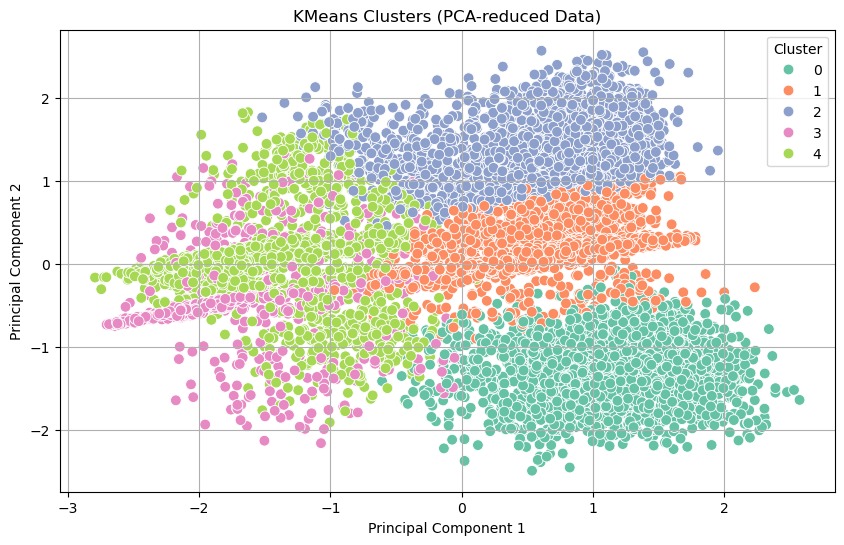

In [51]:
kmeans = KMeans(n_clusters=elbow_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title('KMeans Clusters (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### 16. DBSCAN Clustering : Attempt DBSCAN clustering on the principal components and evaluate the results.

In [52]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
epss = [3.7,3.6,3.5,3.4,3.3,3.2,3.1,3.0,2.9,2.8,2.7]
for ep in epss:
    print(f'----- {ep}')
    X_for_dbscan = X_pca
    dbscan = DBSCAN(eps=ep, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_for_dbscan)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")
    if n_clusters > 1:
        sil_score = silhouette_score(X_for_dbscan, dbscan_labels)
        print(f"Silhouette Score: {sil_score:.4f}")
    else:
        print("Silhouette Score: Not applicable (less than 2 clusters)")

----- 3.7
Estimated number of clusters: 1
Estimated number of noise points: 15
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.6
Estimated number of clusters: 1
Estimated number of noise points: 37
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.5
Estimated number of clusters: 1
Estimated number of noise points: 79
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.4
Estimated number of clusters: 1
Estimated number of noise points: 167
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.3
Estimated number of clusters: 1
Estimated number of noise points: 339
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.2
Estimated number of clusters: 2
Estimated number of noise points: 631
Silhouette Score: 0.0768
----- 3.1
Estimated number of clusters: 1
Estimated number of noise points: 1002
Silhouette Score: Not applicable (less than 2 clusters)
----- 3.0
Estimated number of clusters: 3
Estimated number of noise points: 1481


In [53]:
from sklearn.neighbors import NearestNeighbors

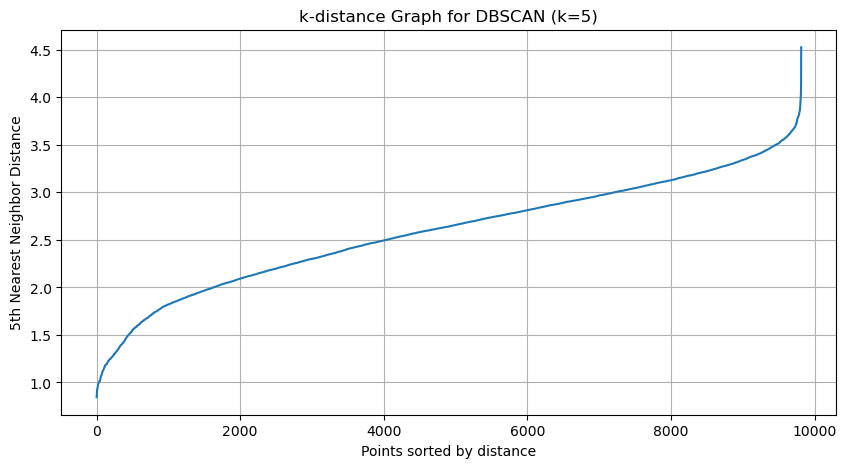

In [54]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


In [55]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

X_for_dbscan = X_pca
dbscan = DBSCAN(eps=3.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_for_dbscan)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Step 3: Evaluate clustering quality
if n_clusters > 1:
    sil_score = silhouette_score(X_for_dbscan, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
else:
    print("Silhouette Score: Not applicable (less than 2 clusters)")

Estimated number of clusters: 2
Estimated number of noise points: 631
Silhouette Score: 0.0768


#### 17. Conclusion : Conclude the analysis by summarizing the steps taken and the findings from the clustering analysis.

In [56]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
score = silhouette_score(X_pca, kmeans_labels)
print(f"KMeans Silhouette Score: {score:.4f}")

KMeans Silhouette Score: 0.0991


Interpretation:
A silhouette score of 0.0991 is still quite low, meaning:
The clusters are not well separated,
Data points are not clearly closer to their own cluster vs others,
The structure in the data may not be naturally clusterable (at least linearly).

Both KMeans and DBSCAN are struggling to find strong, well-separated clusters.
This can happen if:
The features (even after PCA) don't contain meaningful group structure, or
The clusters are not globular (KMeans assumes spherical clusters),
The distance-based approach (like Euclidean) is not suited to your data.

In [57]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg.fit_predict(X_pca)

from sklearn.metrics import silhouette_score
score = silhouette_score(X_pca, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {score:.4f}")


Agglomerative Clustering Silhouette Score: 0.0946


DBSCAN (eps=3.2) with 3	clusters score is 0.0768
KMeans with 5 clusters score is 0.0991
Agglomerative with 3 clusters score is 0.0946

Determines:
KMeans has the best (yet modest) score, meaning it creates slightly more distinct clusters compared to the others.
All scores are < 0.2, which generally means:
There’s weak natural clustering in your dataset.
It may still be useful for exploratory segmentation, but not reliable for production or strong inferences.

In [58]:
#!pip install umap-learn

In [59]:
import umap.umap_ as umap

In [60]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_umap)
score = silhouette_score(X_umap, labels)
print(f"UMAP + KMeans Silhouette Score: {score:.4f}")

UMAP + KMeans Silhouette Score: 0.5216


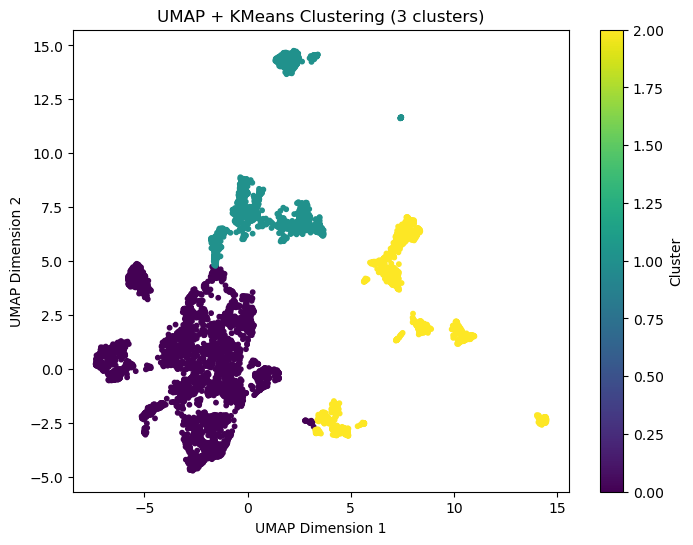

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='viridis', s=10)
plt.title('UMAP + KMeans Clustering (3 clusters)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster')
plt.show()